In [ ]:
import os
import numpy as np
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [ ]:
# Load Dataset and Preprocess
def load_and_preprocess_data(DATA_DIR):
    categories = os.listdir(DATA_DIR)
    data = []

    for category in categories:
        path = os.path.join(DATA_DIR, category)
        label = categories.index(category)

        for img in tqdm(os.listdir(path)):
            try:
                img_path = os.path.join(path, img)
                img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # Convert to grayscale
                img_array = cv2.resize(img_array, (32, 32))  # Resize to 32x32
                data.append([img_array, label])
            except Exception as e:
                pass

    random.shuffle(data)
    return data, categories

In [ ]:
# Manhattan (L1) Distance
def manhattan_distance(x1, x2):
    return np.sum(np.abs(x1 - x2))

# Euclidean (L2) Distance
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2))

In [ ]:
# KNN Classifier
def knn_predict(test_instance, train_data, k, distance_metric):
    distances = []

    for train_instance in train_data:
        train_image, train_label = train_instance
        if distance_metric == 'l1':
            dist = manhattan_distance(test_instance, train_image)
        elif distance_metric == 'l2':
            dist = euclidean_distance(test_instance, train_image)
        distances.append((dist, train_label))

    # Sort by distance and take top k
    distances.sort(key=lambda x: x[0])
    top_k = distances[:k]

    # Get the most common class among the top k
    class_votes = {}
    for d in top_k:
        label = d[1]
        if label in class_votes:
            class_votes[label] += 1
        else:
            class_votes[label] = 1

    # Return the class with the most votes
    return max(class_votes, key=class_votes.get)

In [ ]:
# K-Fold Cross-Validation
def k_fold_cross_validation(data, k_values, distance_metric, folds=5):
    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    accuracies = {k: [] for k in k_values}

    for train_index, test_index in kf.split(data):
        train_data = [data[i] for i in train_index]
        test_data = [data[i] for i in test_index]

        for k in k_values:
            correct = 0
            for test_instance, test_label in test_data:
                prediction = knn_predict(test_instance, train_data, k, distance_metric)
                if prediction == test_label:
                    correct += 1
            accuracy = correct / len(test_data)
            accuracies[k].append(accuracy)

# Average accuracies over all folds
    avg_accuracies = {k: np.mean(accuracies[k]) for k in k_values}
    return avg_accuracies

# Plot Accuracy for both Distance Metrics
def plot_results(k_values, manhattan_accuracies, euclidean_accuracies):
    plt.plot(k_values, list(manhattan_accuracies.values()), label='Manhattan (L1)', marker='o')
    plt.plot(k_values, list(euclidean_accuracies.values()), label='Euclidean (L2)', marker='s')
    plt.xlabel('K')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs K for Manhattan (L1) and Euclidean (L2)')
    plt.legend()
    plt.grid(True)
    plt.show()


In [ ]:
# Display Top 5 Predictions
def display_top_5_predictions(data, train_data, k, distance_metric):
    for i, (img, label) in enumerate(data[:5]):
        prediction = knn_predict(img, train_data, k, distance_metric)
        plt.imshow(img, cmap='gray')
        plt.title(f"Prediction: {prediction}, Actual: {label}")
        plt.show()

100%|██████████| 1000/1000 [00:27<00:00, 37.03it/s]


Evaluating Manhattan (L1) Distance...
Evaluating Euclidean (L2) Distance...


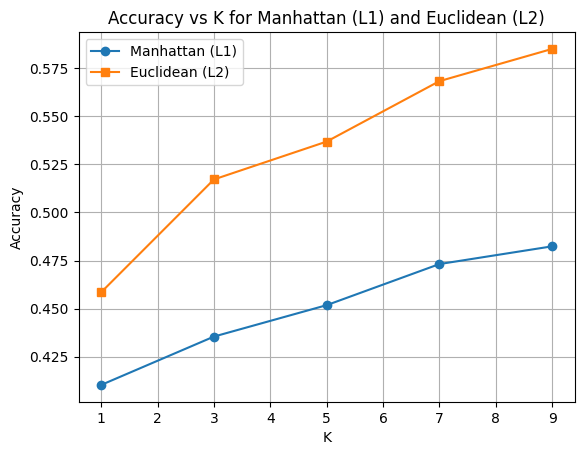

Displaying top 5 predictions using K=9 and Manhattan distance.


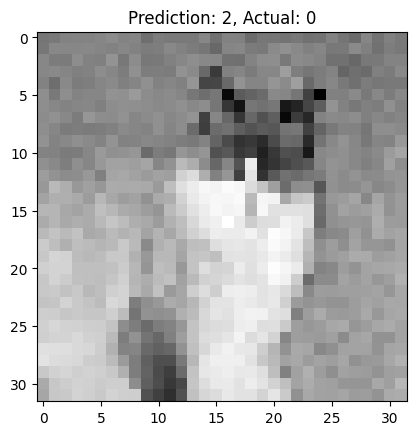

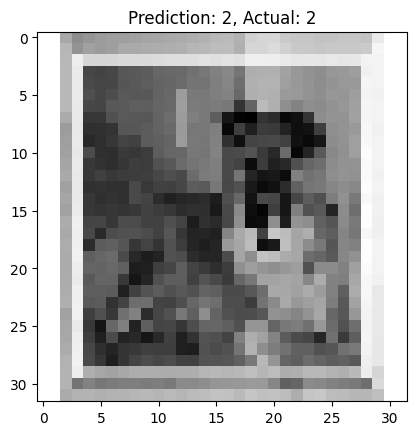

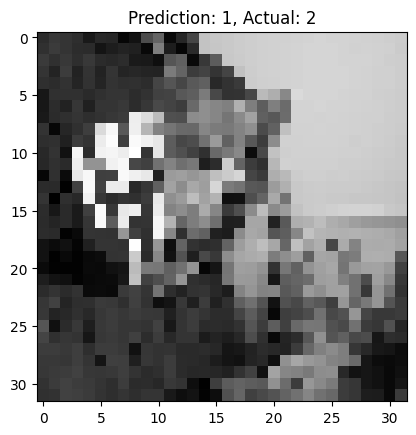

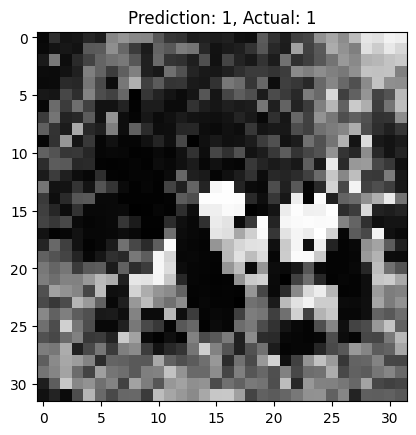

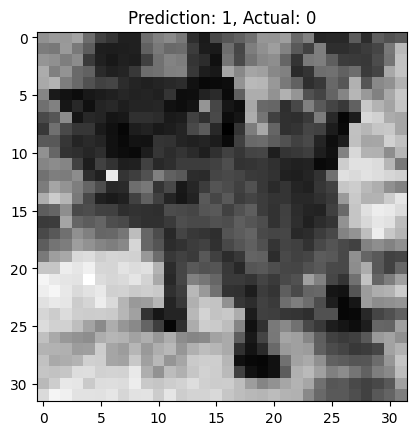

In [ ]:
# Main Execution
if __name__ == "__main__":
    DATA_DIR = '/content/drive/MyDrive/archive/animals/animals'  # Update this path to your dataset
    data, categories = load_and_preprocess_data(DATA_DIR)

    # Split the data into training and testing
    k_values = [1, 3, 5, 7, 9]

    # Perform 5-Fold Cross-Validation for Manhattan and Euclidean distances
    print("Evaluating Manhattan (L1) Distance...")
    manhattan_accuracies = k_fold_cross_validation(data, k_values, distance_metric='l1')

    print("Evaluating Euclidean (L2) Distance...")
    euclidean_accuracies = k_fold_cross_validation(data, k_values, distance_metric='l2')

    # Plot Results
    plot_results(k_values, manhattan_accuracies, euclidean_accuracies)

    # Display Top 5 Predictions using the best performing K
    best_k = max(manhattan_accuracies, key=manhattan_accuracies.get)
    print(f"Displaying top 5 predictions using K={best_k} and Manhattan distance.")
    display_top_5_predictions(data, data[:3000], best_k, distance_metric='l1')